![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [9]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

filename_features = "../Dados/UCI HAR Dataset/UCI HAR Dataset/features.txt"
filename_labels = "../Dados/UCI HAR Dataset/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "../Dados/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "../Dados/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "../Dados/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "../Dados/UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "../Dados/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "../Dados/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, sep=r'\s+', header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features['nome_var'].tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, sep=r'\s+', header=None, names=features['nome_var'].tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [4]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 266 ms
Wall time: 273 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [13]:
max_components = 50

pca_no_std = PCA(n_components=max_components)

X_train_pca_no_std = pca_no_std.fit_transform(X_train)

var_no_std = pca_no_std.explained_variance_
var_ratio_no_std = pca_no_std.explained_variance_ratio_
cumulative_var_ratio_no_std = np.cumsum(var_ratio_no_std)
components_for_90_no_std = np.argmax(cumulative_var_ratio_no_std >= 0.9) + 1

In [15]:
pca_std = PCA(n_components=max_components)
X_train_pca_std = pca_std.fit_transform(X_train_pad)

var_std = pca_std.explained_variance_
var_ratio_std = pca_std.explained_variance_ratio_
cumulative_var_ratio_std = np.cumsum(var_ratio_std)

components_for_90_std = np.argmax(cumulative_var_ratio_std >= 0.9) + 1

In [17]:
n_components_to_show = 20  # Mostramos apenas as primeiras componentes no relatório

comparison_df = pd.DataFrame({
    'Componente': list(range(1, n_components_to_show + 1)),
    'Variância (Sem Padron.)': var_no_std[:n_components_to_show],
    'Variância (Com Padron.)': var_std[:n_components_to_show],
    'Variância Acumulada (Sem Padron.)': np.cumsum(var_no_std)[:n_components_to_show],
    'Variância Acumulada (Com Padron.)': np.cumsum(var_std)[:n_components_to_show],
    'Variância % (Sem Padron.)': var_ratio_no_std[:n_components_to_show] * 100,
    'Variância % (Com Padron.)': var_ratio_std[:n_components_to_show] * 100,
    'Variância % Acum. (Sem Padron.)': cumulative_var_ratio_no_std[:n_components_to_show] * 100,
    'Variância % Acum. (Com Padron.)': cumulative_var_ratio_std[:n_components_to_show] * 100
})

# Imprimindo os resultados
print("Comparação das primeiras componentes principais com e sem padronização:")
pd.set_option('display.precision', 4)
print(comparison_df.to_string(index=False))

print("\nNúmero de componentes necessárias para explicar 90% da variância:")
print(f"Sem padronização: {components_for_90_no_std} componentes")
print(f"Com padronização: {components_for_90_std} componentes")

Comparação das primeiras componentes principais com e sem padronização:
 Componente  Variância (Sem Padron.)  Variância (Com Padron.)  Variância Acumulada (Sem Padron.)  Variância Acumulada (Com Padron.)  Variância % (Sem Padron.)  Variância % (Com Padron.)  Variância % Acum. (Sem Padron.)  Variância % Acum. (Com Padron.)
          1                  34.8236                 284.8824                            34.8236                           284.8824                    62.5544                    50.7812                          62.5544                          50.7812
          2                   2.7350                  36.9176                            37.5587                           321.8000                     4.9130                     6.5807                          67.4675                          57.3619
          3                   2.2944                  15.7441                            39.8531                           337.5441                     4.1215              

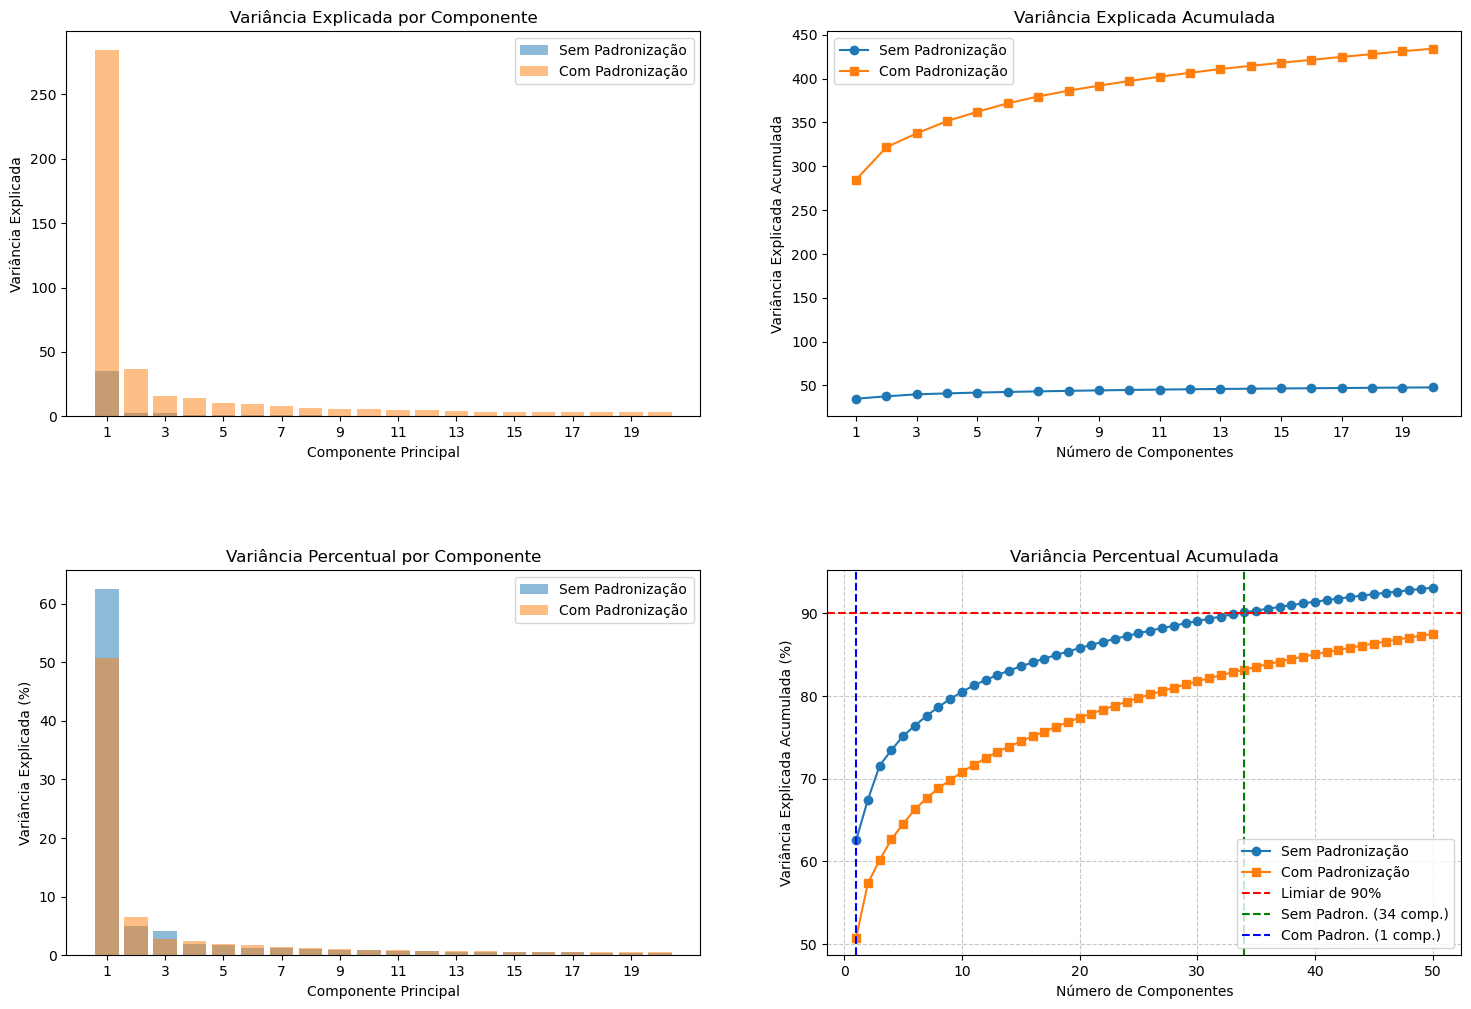

In [18]:
plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: Variância explicada por componente
plt.subplot(2, 2, 1)
plt.bar(range(1, n_components_to_show + 1), var_no_std[:n_components_to_show], alpha=0.5, label='Sem Padronização')
plt.bar(range(1, n_components_to_show + 1), var_std[:n_components_to_show], alpha=0.5, label='Com Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.title('Variância Explicada por Componente')
plt.legend()
plt.xticks(range(1, n_components_to_show + 1, 2))

# Gráfico 2: Variância explicada acumulada
plt.subplot(2, 2, 2)
plt.plot(range(1, n_components_to_show + 1), np.cumsum(var_no_std)[:n_components_to_show], 'o-', label='Sem Padronização')
plt.plot(range(1, n_components_to_show + 1), np.cumsum(var_std)[:n_components_to_show], 's-', label='Com Padronização')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada')
plt.legend()
plt.xticks(range(1, n_components_to_show + 1, 2))

# Gráfico 3: Variância percentual por componente
plt.subplot(2, 2, 3)
plt.bar(range(1, n_components_to_show + 1), var_ratio_no_std[:n_components_to_show] * 100, alpha=0.5, label='Sem Padronização')
plt.bar(range(1, n_components_to_show + 1), var_ratio_std[:n_components_to_show] * 100, alpha=0.5, label='Com Padronização')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada (%)')
plt.title('Variância Percentual por Componente')
plt.legend()
plt.xticks(range(1, n_components_to_show + 1, 2))

# Gráfico 4: Variância percentual acumulada
plt.subplot(2, 2, 4)
plt.plot(range(1, max_components + 1), cumulative_var_ratio_no_std * 100, 'o-', label='Sem Padronização')
plt.plot(range(1, max_components + 1), cumulative_var_ratio_std * 100, 's-', label='Com Padronização')
plt.axhline(y=90, color='r', linestyle='--', label='Limiar de 90%')
plt.axvline(x=components_for_90_no_std, color='g', linestyle='--', label=f'Sem Padron. ({components_for_90_no_std} comp.)')
plt.axvline(x=components_for_90_std, color='b', linestyle='--', label=f'Com Padron. ({components_for_90_std} comp.)')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada (%)')
plt.title('Variância Percentual Acumulada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


- Sem padronização: 34 componentes
- Com padronização: 1 componente

A escolha de 34 componentes sem padronização deve-se ao fato de que a variância explicada por cada componente diminui lentamente. Observando a coluna "Variância % Acum. (Sem Padron.)", vemos que são necessários 34 componentes para atingir aproximadamente 90% da variância total.

Em contraste, com a padronização, o primeiro componente explica uma parcela muito maior da variância (50,78%), e a variância acumulada atinge 90% com apenas 1 componente. Essa diferença ocorre porque a padronização escala os dados, dando peso igual a cada variável na PCA. Sem padronização, variáveis com escalas originais maiores dominam os primeiros componentes principais.



## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [ ]:
%%time
X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

pca_raw = PCA(n_components=10)
X_train_pca_raw = pca_raw.fit_transform(X_train)
X_test_pca_raw = pca_raw.transform(X_test)

pca_pad = PCA(n_components=10)
X_train_pca_pad = pca_pad.fit_transform(X_train_pad)
X_test_pca_pad = pca_pad.transform(X_test_pad)

CPU times: total: 1.19 s
Wall time: 757 ms


In [ ]:
tree_raw = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_raw.fit(X_train_pca_raw, y_train)

tree_pad = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_pad.fit(X_train_pca_pad, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)

In [26]:
train_acc_raw = accuracy_score(y_train, tree_raw.predict(X_train_pca_raw))
test_acc_raw = accuracy_score(y_test, tree_raw.predict(X_test_pca_raw))

train_acc_pad = accuracy_score(y_train, tree_pad.predict(X_train_pca_pad))
test_acc_pad = accuracy_score(y_test, tree_pad.predict(X_test_pca_pad))

# Resultados
print("Resultados SEM padronização:")
print(f"Acurácia treino: {train_acc_raw:.4f}")
print(f"Acurácia teste: {test_acc_raw:.4f}\n")

print("Resultados COM padronização:")
print(f"Acurácia treino: {train_acc_pad:.4f}")
print(f"Acurácia teste: {test_acc_pad:.4f}")

Resultados SEM padronização:
Acurácia treino: 0.8935
Acurácia teste: 0.8235

Resultados COM padronização:
Acurácia treino: 0.8588
Acurácia teste: 0.7740
